# GRU Text Classification - IMDB Sentiment

**Group 9 - Text Classification Project**  
**Dataset:** IMDB Movie Reviews (Sentiment Classification)  
**Model:** Gated Recurrent Unit (GRU)
**Member:** Alice
## Objectives
1. Implement GRU with **three embedding approaches**: TF-IDF, GloVe, Word2Vec (Skip-gram)
2. Train and tune each model with the same preprocessing strategy
3. Evaluate and compare performance with confusion matrices, ROC curves, and metrics
4. Generate comparison visualizations for the report

## Embedding-Model Combinations
| Embedding | Input representation | Use case |
|-----------|---------------------|----------|
| **TF-IDF** | Document vector (1 timestep) | Sparse bag-of-words style |
| **GloVe** | Sequence of pre-trained word vectors | Dense, pre-trained |
| **Word2Vec** | Sequence of custom-trained word vectors | Dense, domain-specific |

## 1. Imports and Configuration

In [ ]:
# Data and numerical
import pandas as pd
import numpy as np
import re
import json
import time
import os
import sys
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, GRU, Embedding, Dropout, Masking
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import set_random_seed

# Word embeddings
from gensim.models import Word2Vec

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK (stopwords)
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print("✅ All imports successful!")
print("✅ Ready to proceed with data loading and preprocessing")

TensorFlow version: 2.20.0
✅ All imports successful!
✅ Ready to proceed with data loading and preprocessing


In [ ]:
# Paths (notebook is in notebooks/)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "IMDB Dataset.csv"
GLOVE_PATH = PROJECT_ROOT / "data" / "embeddings" / "glove.6B.100d.txt"
RESULTS_DIR = PROJECT_ROOT / "results" / "member4_gru"
FIGURES_DIR = PROJECT_ROOT / "figures" / "results"
FIGURES_GRU = PROJECT_ROOT / "figures" / "gru"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_GRU.mkdir(parents=True, exist_ok=True)

print(f"Data path: {DATA_RAW}")
print(f"GloVe path: {GLOVE_PATH}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_GRU}")

Data path: c:\Users\ngami\Downloads\Group_9_Text_classification\data\raw\IMDB Dataset.csv
GloVe path: c:\Users\ngami\Downloads\Group_9_Text_classification\data\embeddings\glove.6B.100d.txt
Results directory: c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru
Figures directory: c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru


## 2. Load and Preprocess Data

In [ ]:
# Load IMDB dataset
df = pd.read_csv(DATA_RAW)
print(f"Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['sentiment'].value_counts())
print(f"\nFirst few rows:")
df.head()

Dataset loaded: (50000, 2)
Columns: ['review', 'sentiment']

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

First few rows:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Text preprocessing function
def preprocess_text(text, remove_stopwords=False):
    """Clean and preprocess text"""
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords if specified
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Preview preprocessing
sample_text = df['review'].iloc[0]
print("Original text (first 200 chars):")
print(sample_text[:200])
print("\n" + "="*80 + "\n")
print("Preprocessed (with stopwords):")
print(preprocess_text(sample_text, remove_stopwords=False)[:200])
print("\n" + "="*80 + "\n")
print("Preprocessed (without stopwords):")
print(preprocess_text(sample_text, remove_stopwords=True)[:200])

Original text (first 200 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo


Preprocessed (with stopwords):
one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut


Preprocessed (without stopwords):
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show 


## 3. Data Splitting

Use the same split as other team members: 70% train, 10% validation, 20% test

In [ ]:
# Encode labels: positive=1, negative=0
df['label'] = (df['sentiment'] == 'positive').astype(int)

# Split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label']
)

# Split temp: 10% val (1/3 of 30%), 20% test (2/3 of 30%)
val_df, test_df = train_test_split(
    temp_df, test_size=2/3, random_state=RANDOM_SEED, stratify=temp_df['label']
)

print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val set:   {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set:  {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print("\nTrain class distribution:", train_df['label'].value_counts().to_dict())
print("Val class distribution:", val_df['label'].value_counts().to_dict())
print("Test class distribution:", test_df['label'].value_counts().to_dict())

Train set: 35000 samples (70.0%)
Val set:   5000 samples (10.0%)
Test set:  10000 samples (20.0%)

Train class distribution: {1: 17500, 0: 17500}
Val class distribution: {0: 2500, 1: 2500}
Test class distribution: {1: 5000, 0: 5000}


## 4. Preprocess Text for All Embeddings

Preprocess the text once for all embedding approaches to ensure consistency.

In [ ]:
# Preprocess all text variations upfront
print("Preprocessing text for all embedding approaches...")

# For TF-IDF: Remove stopwords (sparse representation benefits from dimensionality reduction)
train_df['text_tfidf'] = train_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
val_df['text_tfidf'] = val_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
test_df['text_tfidf'] = test_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

# For GloVe & Word2Vec: Keep stopwords (dense embeddings capture semantic context)
train_df['text_seq'] = train_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
val_df['text_seq'] = val_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df['text_seq'] = test_df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=False))

print(f"✓ Preprocessed {len(train_df)} training samples")
print(f"✓ Preprocessed {len(val_df)} validation samples")
print(f"✓ Preprocessed {len(test_df)} test samples")
print("\nSample preprocessed text (TF-IDF):")
print(train_df['text_tfidf'].iloc[0][:150])
print("\nSample preprocessed text (Sequence):")
print(train_df['text_seq'].iloc[0][:150])

Preprocessing text for all embedding approaches...
✓ Preprocessed 35000 training samples
✓ Preprocessed 5000 validation samples
✓ Preprocessed 10000 test samples

Sample preprocessed text (TF-IDF):
want see true thriller rent director screenwriter scream doesnt feature overacting overpaid tv actors passing stars run mill special effects bonanza i

Sample preprocessed text (Sequence):
if you want to see a true thriller rent this its not from the director or screenwriter of scream doesnt feature overacting overpaid tv actors passing 


---
# Part 5: GRU with TF-IDF
---

TF-IDF creates sparse representations. For sequence models, we'll treat the TF-IDF vector as a single timestep.
**Note:** This section can be run independently after sections 1-4.

In [ ]:
print("="*80)
print("GRU + TF-IDF")
print("="*80)

# Create TF-IDF features from preprocessed text
vectorizer_tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True
)

X_train_tfidf = vectorizer_tfidf.fit_transform(train_df['text_tfidf']).toarray()
X_val_tfidf = vectorizer_tfidf.transform(val_df['text_tfidf']).toarray()
X_test_tfidf = vectorizer_tfidf.transform(test_df['text_tfidf']).toarray()

# Reshape for GRU: (samples, timesteps=1, features)
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_val_tfidf = X_val_tfidf.reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])
X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_val_tfidf shape: {X_val_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

GRU + TF-IDF


X_train_tfidf shape: (35000, 1, 5000)
X_val_tfidf shape: (5000, 1, 5000)
X_test_tfidf shape: (10000, 1, 5000)


In [ ]:
# Build GRU model for TF-IDF
model_gru_tfidf = Sequential([
    Masking(mask_value=0.0, input_shape=(1, 5000)),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='GRU_TFIDF')

model_gru_tfidf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_gru_tfidf.summary()

Model: "GRU_TFIDF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 1, 5000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │     1,969,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,978,241 (7.55 MB)

 Trainable params: 1,978,241 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train GRU + TF-IDF
print("\nTraining GRU + TF-IDF...")

callbacks_tfidf = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

start_time = time.time()
history_tfidf = model_gru_tfidf.fit(
    X_train_tfidf, y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_tfidf,
    verbose=1
)
training_time_tfidf = time.time() - start_time

print(f"\nTraining completed in {training_time_tfidf:.2f} seconds")


Training GRU + TF-IDF...
Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.8632 - loss: 0.3341 - val_accuracy: 0.8904 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9069 - loss: 0.2331 - val_accuracy: 0.8860 - val_loss: 0.2786 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9182 - loss: 0.2073 - val_accuracy: 0.8816 - val_loss: 0.2978 - learning_rate: 0.0010
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9314 - loss: 0.1693 - val_accuracy: 0.8828 - val_loss: 0.3221 - learning_rate: 5.0000e-04

Training completed in 130.18 seconds


In [ ]:
# Evaluate GRU + TF-IDF
y_pred_proba_tfidf = model_gru_tfidf.predict(X_test_tfidf)
y_pred_tfidf = (y_pred_proba_tfidf > 0.5).astype(int).flatten()

# Calculate metrics
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf)
rec_tfidf = recall_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

# ROC-AUC
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_pred_proba_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

print("\n" + "="*80)
print("GRU + TF-IDF Results")
print("="*80)
print(f"Accuracy:  {acc_tfidf:.4f}")
print(f"Precision: {prec_tfidf:.4f}")
print(f"Recall:    {rec_tfidf:.4f}")
print(f"F1-Score:  {f1_tfidf:.4f}")
print(f"ROC-AUC:   {roc_auc_tfidf:.4f}")
print(f"Training Time: {training_time_tfidf:.2f}s")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

GRU + TF-IDF Results
Accuracy:  0.8914
Precision: 0.8888
Recall:    0.8948
F1-Score:  0.8918
ROC-AUC:   0.9592
Training Time: 130.18s


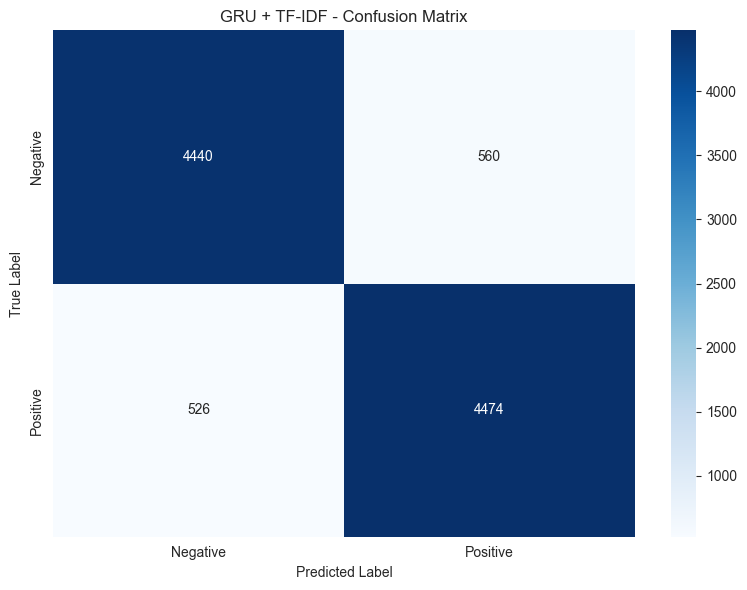

Confusion Matrix saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\confusion_matrix_gru_tfidf.png


In [ ]:
# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('GRU + TF-IDF - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'confusion_matrix_gru_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion Matrix saved to {FIGURES_GRU / 'confusion_matrix_gru_tfidf.png'}")

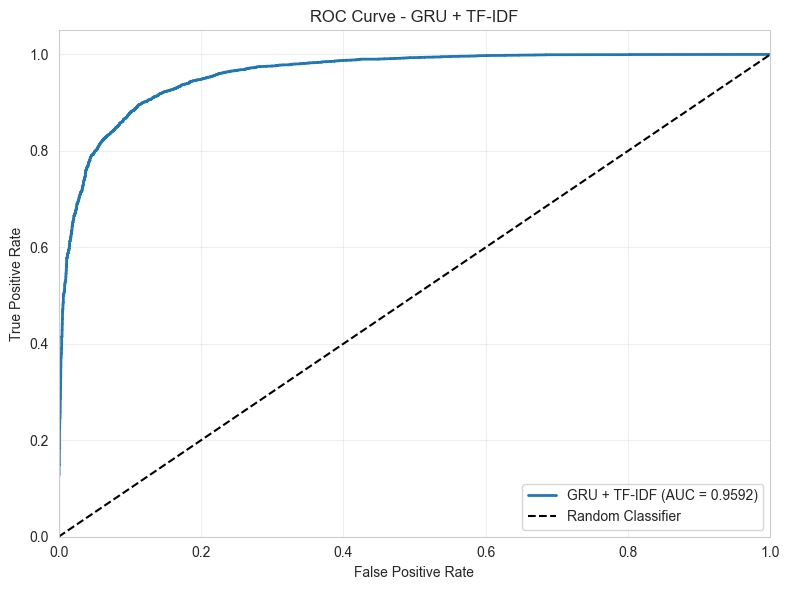

ROC Curve saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\roc_curve_gru_tfidf.png


In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'GRU + TF-IDF (AUC = {roc_auc_tfidf:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU + TF-IDF')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'roc_curve_gru_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC Curve saved to {FIGURES_GRU / 'roc_curve_gru_tfidf.png'}")

In [ ]:
# Save model and results
model_gru_tfidf.save(RESULTS_DIR / 'model_gru_tfidf.keras')

results_tfidf = {
    'model': 'GRU',
    'embedding': 'TF-IDF',
    'accuracy': float(acc_tfidf),
    'precision': float(prec_tfidf),
    'recall': float(rec_tfidf),
    'f1_score': float(f1_tfidf),
    'roc_auc': float(roc_auc_tfidf),
    'training_time': float(training_time_tfidf)
}

with open(RESULTS_DIR / 'results_gru_tfidf.json', 'w') as f:
    json.dump(results_tfidf, f, indent=4)

print(f"Model saved to {RESULTS_DIR / 'model_gru_tfidf.keras'}")
print(f"Results saved to {RESULTS_DIR / 'results_gru_tfidf.json'}")

Model saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\model_gru_tfidf.keras
Results saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\results_gru_tfidf.json


---
# Part 6: GRU with GloVe
---

Use pre-trained GloVe embeddings (glove.6B.100d.txt)
**Note:** This section can be run independently after sections 1-4.

In [ ]:
print("="*80)
print("GRU + GloVe")
print("="*80)

# Use preprocessed sequence text (already created in section 4)
MAX_WORDS = 20000
MAX_LEN = 200

tokenizer_glove = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer_glove.fit_on_texts(train_df['text_seq'])

X_train_seq_glove = tokenizer_glove.texts_to_sequences(train_df['text_seq'])
X_val_seq_glove = tokenizer_glove.texts_to_sequences(val_df['text_seq'])
X_test_seq_glove = tokenizer_glove.texts_to_sequences(test_df['text_seq'])

X_train_pad_glove = pad_sequences(X_train_seq_glove, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad_glove = pad_sequences(X_val_seq_glove, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad_glove = pad_sequences(X_test_seq_glove, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer_glove.word_index)}")
print(f"X_train_pad_glove shape: {X_train_pad_glove.shape}")
print(f"X_val_pad_glove shape: {X_val_pad_glove.shape}")
print(f"X_test_pad_glove shape: {X_test_pad_glove.shape}")

GRU + GloVe


Vocabulary size: 170412
X_train_pad_glove shape: (35000, 200)
X_val_pad_glove shape: (5000, 200)
X_test_pad_glove shape: (10000, 200)


In [ ]:
# Load GloVe embeddings
print("\nLoading GloVe embeddings...")
embeddings_index_glove = {}

with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index_glove[word] = coefs

print(f"Loaded {len(embeddings_index_glove)} word vectors from GloVe")

# Create embedding matrix
EMBEDDING_DIM = 100
vocab_size = min(len(tokenizer_glove.word_index) + 1, MAX_WORDS)
embedding_matrix_glove = np.zeros((vocab_size, EMBEDDING_DIM))

oov_count = 0
for word, i in tokenizer_glove.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector
    else:
        oov_count += 1
        # Random initialization for OOV words
        embedding_matrix_glove[i] = np.random.uniform(-0.1, 0.1, EMBEDDING_DIM)

print(f"Embedding matrix shape: {embedding_matrix_glove.shape}")
print(f"Out-of-vocabulary words: {oov_count} ({oov_count/len(tokenizer_glove.word_index)*100:.2f}%)")


Loading GloVe embeddings...
Loaded 400000 word vectors from GloVe
Embedding matrix shape: (20000, 100)
Out-of-vocabulary words: 738 (0.43%)


In [ ]:
# Build GRU model with GloVe
model_gru_glove = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix_glove],
        input_length=MAX_LEN,
        trainable=False,  # Freeze pre-trained embeddings
        name='glove_embedding'
    ),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='GRU_GloVe')

model_gru_glove.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_gru_glove.summary()

Model: "GRU_GloVe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ glove_embedding (Embedding)     │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
# Train GRU + GloVe
print("\nTraining GRU + GloVe...")

callbacks_glove = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

start_time = time.time()
history_glove = model_gru_glove.fit(
    X_train_pad_glove, y_train,
    validation_data=(X_val_pad_glove, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_glove,
    verbose=1
)
training_time_glove = time.time() - start_time

print(f"\nTraining completed in {training_time_glove:.2f} seconds")


Training GRU + GloVe...
Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 150s 268ms/step - accuracy: 0.5342 - loss: 0.6872 - val_accuracy: 0.6990 - val_loss: 0.6371 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 188s 243ms/step - accuracy: 0.5355 - loss: 0.6851 - val_accuracy: 0.5272 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 115s 210ms/step - accuracy: 0.6668 - loss: 0.5755 - val_accuracy: 0.8242 - val_loss: 0.3953 - learning_rate: 0.0010
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 206s 377ms/step - accuracy: 0.8340 - loss: 0.3815 - val_accuracy: 0.8500 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 330s 602ms/step - accuracy: 0.8534 - loss: 0.3412 - val_accuracy: 0.8586 - val_loss: 0.3319 - learning_rate: 0.0010
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 200s 269ms/step - accuracy: 0.8638 - loss: 0.3188 - val_accuracy: 0.8590 - val_loss: 0.3271 - learning_rate: 0.0010
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate GRU + GloVe
y_pred_proba_glove = model_gru_glove.predict(X_test_pad_glove)
y_pred_glove = (y_pred_proba_glove > 0.5).astype(int).flatten()

# Calculate metrics
acc_glove = accuracy_score(y_test, y_pred_glove)
prec_glove = precision_score(y_test, y_pred_glove)
rec_glove = recall_score(y_test, y_pred_glove)
f1_glove = f1_score(y_test, y_pred_glove)

# ROC-AUC
fpr_glove, tpr_glove, _ = roc_curve(y_test, y_pred_proba_glove)
roc_auc_glove = auc(fpr_glove, tpr_glove)

print("\n" + "="*80)
print("GRU + GloVe Results")
print("="*80)
print(f"Accuracy:  {acc_glove:.4f}")
print(f"Precision: {prec_glove:.4f}")
print(f"Recall:    {rec_glove:.4f}")
print(f"F1-Score:  {f1_glove:.4f}")
print(f"ROC-AUC:   {roc_auc_glove:.4f}")
print(f"Training Time: {training_time_glove:.2f}s")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step

GRU + GloVe Results
Accuracy:  0.8650
Precision: 0.8728
Recall:    0.8546
F1-Score:  0.8636
ROC-AUC:   0.9415
Training Time: 2205.66s


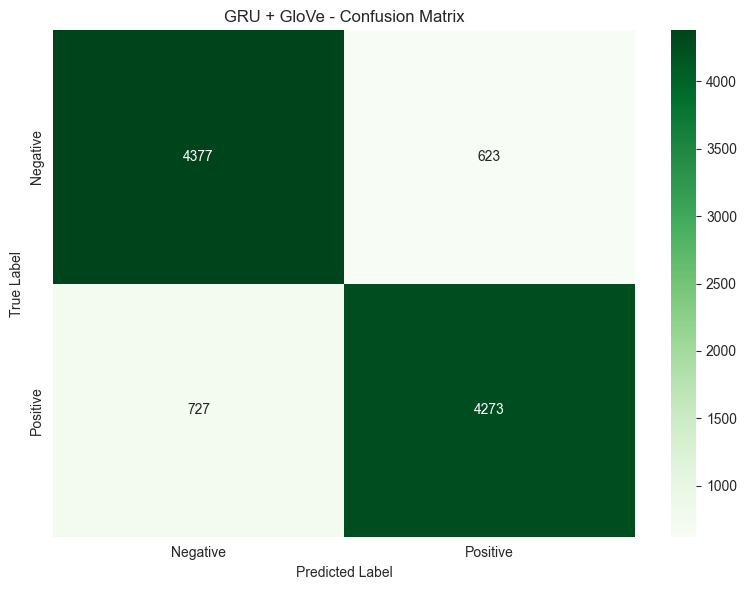

Confusion Matrix saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\confusion_matrix_gru_glove.png


In [ ]:
# Confusion Matrix
cm_glove = confusion_matrix(y_test, y_pred_glove)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('GRU + GloVe - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'confusion_matrix_gru_glove.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion Matrix saved to {FIGURES_GRU / 'confusion_matrix_gru_glove.png'}")

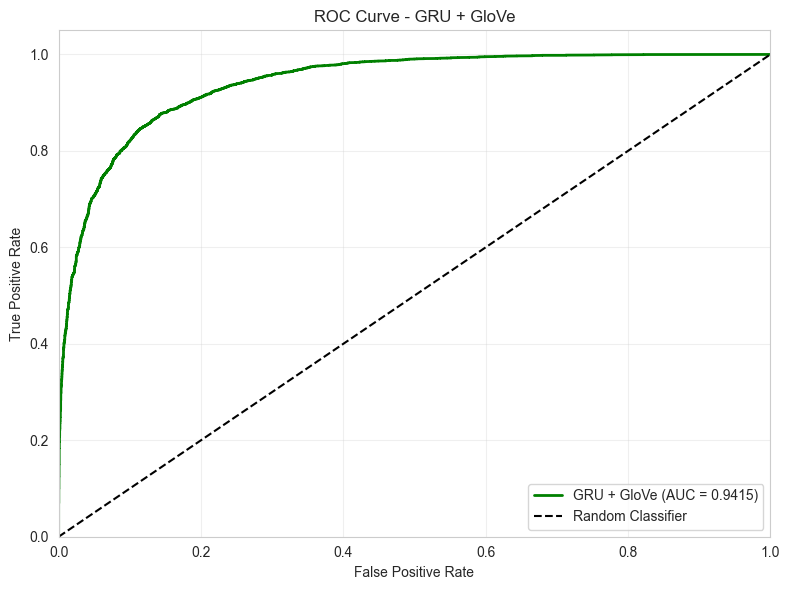

ROC Curve saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\roc_curve_gru_glove.png


In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_glove, tpr_glove, label=f'GRU + GloVe (AUC = {roc_auc_glove:.4f})', linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU + GloVe')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'roc_curve_gru_glove.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC Curve saved to {FIGURES_GRU / 'roc_curve_gru_glove.png'}")

In [ ]:
# Save model and results
model_gru_glove.save(RESULTS_DIR / 'model_gru_glove.keras')

results_glove = {
    'model': 'GRU',
    'embedding': 'GloVe',
    'accuracy': float(acc_glove),
    'precision': float(prec_glove),
    'recall': float(rec_glove),
    'f1_score': float(f1_glove),
    'roc_auc': float(roc_auc_glove),
    'training_time': float(training_time_glove)
}

with open(RESULTS_DIR / 'results_gru_glove.json', 'w') as f:
    json.dump(results_glove, f, indent=4)

print(f"Model saved to {RESULTS_DIR / 'model_gru_glove.keras'}")
print(f"Results saved to {RESULTS_DIR / 'results_gru_glove.json'}")

Model saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\model_gru_glove.keras
Results saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\results_gru_glove.json


---
# Part 7: GRU with Word2Vec
---

Train custom Word2Vec embeddings on the IMDB corpus
**Note:** This section can be run independently after sections 1-4.

In [ ]:
print("="*80)
print("GRU + Word2Vec")
print("="*80)

# Use preprocessed sequence text (already created in section 4)
# Tokenize for Word2Vec training
tokenized_texts = [text.split() for text in train_df['text_seq']]

print(f"Number of documents: {len(tokenized_texts)}")
print(f"First document (first 20 words): {tokenized_texts[0][:20]}")

GRU + Word2Vec
Number of documents: 35000
First document (first 20 words): ['if', 'you', 'want', 'to', 'see', 'a', 'true', 'thriller', 'rent', 'this', 'its', 'not', 'from', 'the', 'director', 'or', 'screenwriter', 'of', 'scream', 'doesnt']


In [ ]:
# Train Word2Vec model
print("\nTraining Word2Vec model...")

w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=2,
    epochs=10,
    sg=1,  # Skip-gram
    workers=4,
    seed=RANDOM_SEED
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"Vector dimension: {w2v_model.vector_size}")

# Test semantic similarity
try:
    similar_words = w2v_model.wv.most_similar('good', topn=5)
    print("\nMost similar words to 'good':")
    for word, score in similar_words:
        print(f"  {word}: {score:.4f}")
except:
    print("\n'good' not in vocabulary")


Training Word2Vec model...
Word2Vec vocabulary size: 67419
Vector dimension: 100

Most similar words to 'good':
  great: 0.7977
  decent: 0.7903
  bad: 0.7588
  moviemost: 0.7400
  nice: 0.7388


In [ ]:
# Create sequences for Word2Vec
tokenizer_w2v = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer_w2v.fit_on_texts(train_df['text_seq'])

X_train_seq_w2v = tokenizer_w2v.texts_to_sequences(train_df['text_seq'])
X_val_seq_w2v = tokenizer_w2v.texts_to_sequences(val_df['text_seq'])
X_test_seq_w2v = tokenizer_w2v.texts_to_sequences(test_df['text_seq'])

X_train_pad_w2v = pad_sequences(X_train_seq_w2v, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad_w2v = pad_sequences(X_val_seq_w2v, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad_w2v = pad_sequences(X_test_seq_w2v, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"X_train_pad_w2v shape: {X_train_pad_w2v.shape}")
print(f"X_val_pad_w2v shape: {X_val_pad_w2v.shape}")
print(f"X_test_pad_w2v shape: {X_test_pad_w2v.shape}")

X_train_pad_w2v shape: (35000, 200)
X_val_pad_w2v shape: (5000, 200)
X_test_pad_w2v shape: (10000, 200)


In [ ]:
# Create Word2Vec embedding matrix
vocab_size_w2v = min(len(tokenizer_w2v.word_index) + 1, MAX_WORDS)
embedding_matrix_w2v = np.zeros((vocab_size_w2v, EMBEDDING_DIM))

oov_count_w2v = 0
for word, i in tokenizer_w2v.word_index.items():
    if i >= MAX_WORDS:
        continue
    try:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix_w2v[i] = embedding_vector
    except KeyError:
        oov_count_w2v += 1
        # Random initialization for OOV
        embedding_matrix_w2v[i] = np.random.uniform(-0.1, 0.1, EMBEDDING_DIM)

print(f"Embedding matrix shape: {embedding_matrix_w2v.shape}")
print(f"Out-of-vocabulary words: {oov_count_w2v} ({oov_count_w2v/len(tokenizer_w2v.word_index)*100:.2f}%)")

Embedding matrix shape: (20000, 100)
Out-of-vocabulary words: 1 (0.00%)


In [ ]:
# Build GRU model with Word2Vec
model_gru_w2v = Sequential([
    Embedding(
        input_dim=vocab_size_w2v,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix_w2v],
        input_length=MAX_LEN,
        trainable=True,  # Fine-tune Word2Vec embeddings
        name='word2vec_embedding'
    ),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='GRU_Word2Vec')

model_gru_w2v.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_gru_w2v.summary()

Model: "GRU_Word2Vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word2vec_embedding (Embedding)  │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train GRU + Word2Vec
print("\nTraining GRU + Word2Vec...")

callbacks_w2v = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

start_time = time.time()
history_w2v = model_gru_w2v.fit(
    X_train_pad_w2v, y_train,
    validation_data=(X_val_pad_w2v, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_w2v,
    verbose=1
)
training_time_w2v = time.time() - start_time

print(f"\nTraining completed in {training_time_w2v:.2f} seconds")


Training GRU + Word2Vec...
Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 271s 488ms/step - accuracy: 0.5301 - loss: 0.6906 - val_accuracy: 0.4980 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 208s 279ms/step - accuracy: 0.6641 - loss: 0.5638 - val_accuracy: 0.8786 - val_loss: 0.2918 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 148s 271ms/step - accuracy: 0.8991 - loss: 0.2590 - val_accuracy: 0.8918 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 153s 279ms/step - accuracy: 0.9368 - loss: 0.1738 - val_accuracy: 0.8916 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 200s 276ms/step - accuracy: 0.9628 - loss: 0.1143 - val_accuracy: 0.8766 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 186s 246ms/step - accuracy: 0.9836 - loss: 0.0563 - val_accuracy: 0.8770 - val_loss: 0.5027 - learning_rate: 5.0000e-04

Training completed in 1166.05 s

In [ ]:
# Evaluate GRU + Word2Vec
y_pred_proba_w2v = model_gru_w2v.predict(X_test_pad_w2v)
y_pred_w2v = (y_pred_proba_w2v > 0.5).astype(int).flatten()

# Calculate metrics
acc_w2v = accuracy_score(y_test, y_pred_w2v)
prec_w2v = precision_score(y_test, y_pred_w2v)
rec_w2v = recall_score(y_test, y_pred_w2v)
f1_w2v = f1_score(y_test, y_pred_w2v)

# ROC-AUC
fpr_w2v, tpr_w2v, _ = roc_curve(y_test, y_pred_proba_w2v)
roc_auc_w2v = auc(fpr_w2v, tpr_w2v)

print("\n" + "="*80)
print("GRU + Word2Vec Results")
print("="*80)
print(f"Accuracy:  {acc_w2v:.4f}")
print(f"Precision: {prec_w2v:.4f}")
print(f"Recall:    {rec_w2v:.4f}")
print(f"F1-Score:  {f1_w2v:.4f}")
print(f"ROC-AUC:   {roc_auc_w2v:.4f}")
print(f"Training Time: {training_time_w2v:.2f}s")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step

GRU + Word2Vec Results
Accuracy:  0.8965
Precision: 0.8983
Recall:    0.8942
F1-Score:  0.8963
ROC-AUC:   0.9589
Training Time: 1166.05s


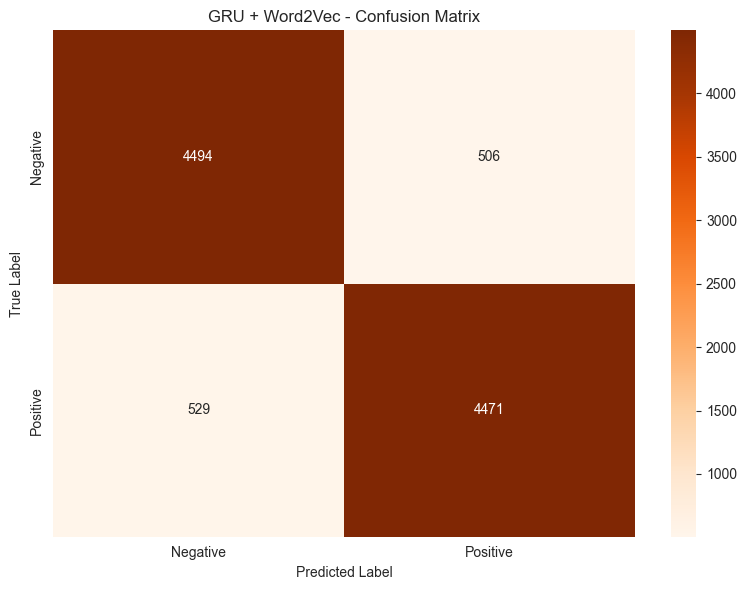

Confusion Matrix saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\confusion_matrix_gru_word2vec.png


In [ ]:
# Confusion Matrix
cm_w2v = confusion_matrix(y_test, y_pred_w2v)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('GRU + Word2Vec - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'confusion_matrix_gru_word2vec.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion Matrix saved to {FIGURES_GRU / 'confusion_matrix_gru_word2vec.png'}")

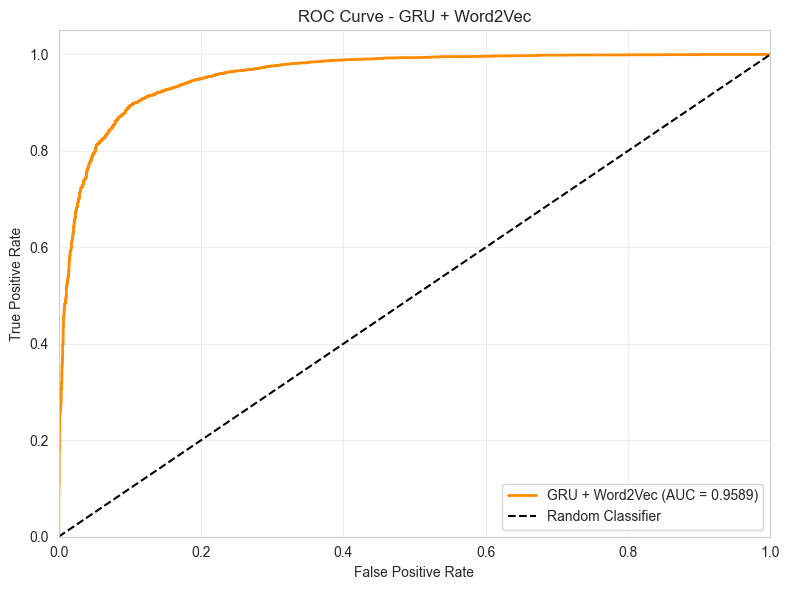

ROC Curve saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\roc_curve_gru_word2vec.png


In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_w2v, tpr_w2v, label=f'GRU + Word2Vec (AUC = {roc_auc_w2v:.4f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU + Word2Vec')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'roc_curve_gru_word2vec.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC Curve saved to {FIGURES_GRU / 'roc_curve_gru_word2vec.png'}")

In [ ]:
# Save model and results
model_gru_w2v.save(RESULTS_DIR / 'model_gru_word2vec.keras')

results_w2v = {
    'model': 'GRU',
    'embedding': 'Word2Vec',
    'accuracy': float(acc_w2v),
    'precision': float(prec_w2v),
    'recall': float(rec_w2v),
    'f1_score': float(f1_w2v),
    'roc_auc': float(roc_auc_w2v),
    'training_time': float(training_time_w2v)
}

with open(RESULTS_DIR / 'results_gru_word2vec.json', 'w') as f:
    json.dump(results_w2v, f, indent=4)

print(f"Model saved to {RESULTS_DIR / 'model_gru_word2vec.keras'}")
print(f"Results saved to {RESULTS_DIR / 'results_gru_word2vec.json'}")

Model saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\model_gru_word2vec.keras
Results saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\results_gru_word2vec.json


---
# Part 8: Comparison and Visualization
---

**Note:** Run this section only after completing all three GRU models (Parts 5, 6, and 7).

In [ ]:
# Create comprehensive comparison table
comparison_data = {
    'Embedding': ['TF-IDF', 'GloVe', 'Word2Vec'],
    'Accuracy': [acc_tfidf, acc_glove, acc_w2v],
    'Precision': [prec_tfidf, prec_glove, prec_w2v],
    'Recall': [rec_tfidf, rec_glove, rec_w2v],
    'F1-Score': [f1_tfidf, f1_glove, f1_w2v],
    'ROC-AUC': [roc_auc_tfidf, roc_auc_glove, roc_auc_w2v],
    'Training Time (s)': [training_time_tfidf, training_time_glove, training_time_w2v]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("GRU Model Comparison - All Embeddings")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save comparison table
comparison_df.to_csv(RESULTS_DIR / 'comparison_table_gru.csv', index=False)
print(f"\nComparison table saved to {RESULTS_DIR / 'comparison_table_gru.csv'}")


GRU Model Comparison - All Embeddings
Embedding  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Training Time (s)
 Word2Vec    0.8965   0.898332  0.8942  0.896261 0.958918        1166.049599
   TF-IDF    0.8914   0.888756  0.8948  0.891768 0.959158         130.176599
    GloVe    0.8650   0.872753  0.8546  0.863581 0.941540        2205.658472

Comparison table saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\comparison_table_gru.csv


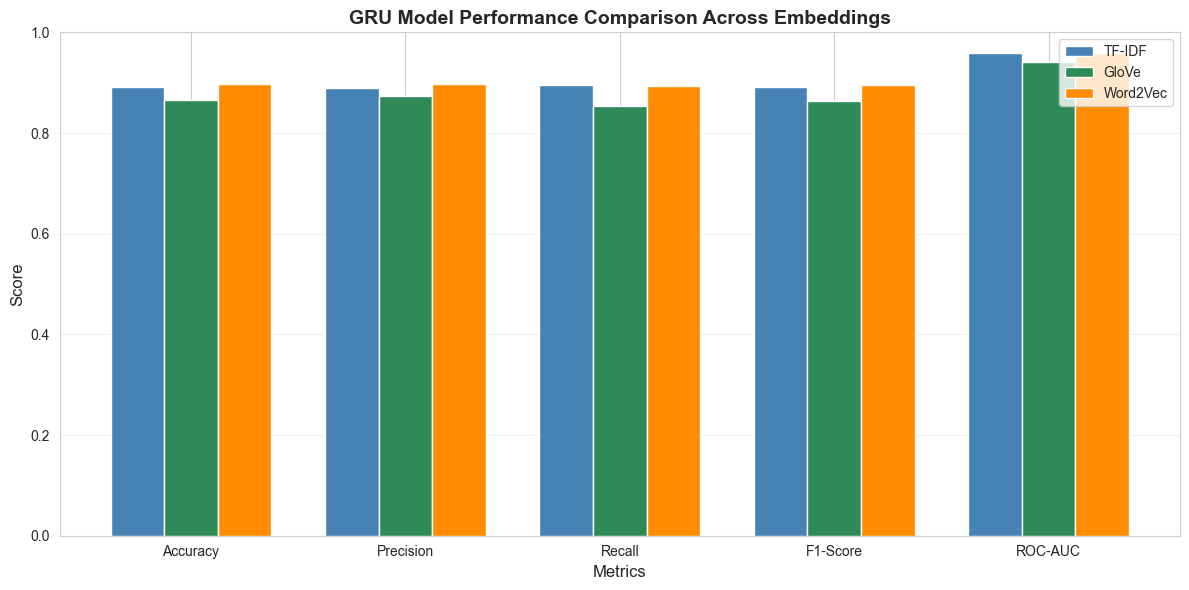

Bar chart saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\gru_all_metrics_comparison.png


In [ ]:
# Visualize comparison - Bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
embeddings = ['TF-IDF', 'GloVe', 'Word2Vec']

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.25

values_tfidf = [acc_tfidf, prec_tfidf, rec_tfidf, f1_tfidf, roc_auc_tfidf]
values_glove = [acc_glove, prec_glove, rec_glove, f1_glove, roc_auc_glove]
values_w2v = [acc_w2v, prec_w2v, rec_w2v, f1_w2v, roc_auc_w2v]

ax.bar(x - width, values_tfidf, width, label='TF-IDF', color='steelblue')
ax.bar(x, values_glove, width, label='GloVe', color='seagreen')
ax.bar(x + width, values_w2v, width, label='Word2Vec', color='darkorange')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('GRU Model Performance Comparison Across Embeddings', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_GRU / 'gru_all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Bar chart saved to {FIGURES_GRU / 'gru_all_metrics_comparison.png'}")

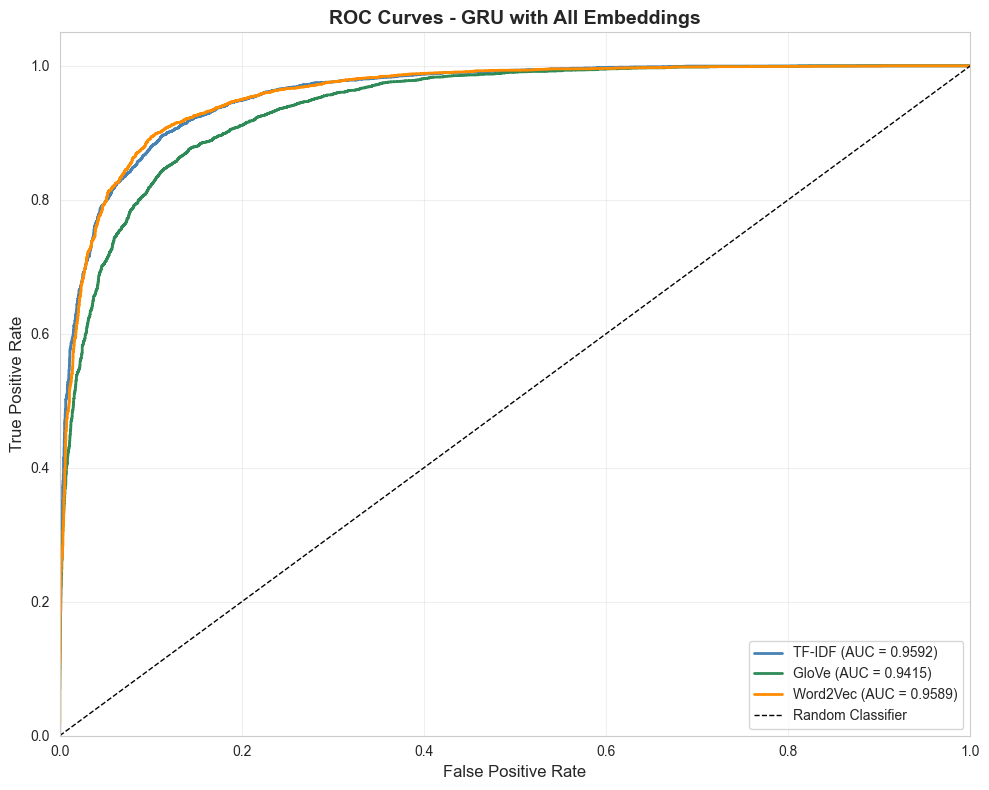

Combined ROC curves saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\roc_curves_all_gru.png


In [ ]:
# Visualize all ROC curves together
plt.figure(figsize=(10, 8))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {roc_auc_tfidf:.4f})', linewidth=2, color='steelblue')
plt.plot(fpr_glove, tpr_glove, label=f'GloVe (AUC = {roc_auc_glove:.4f})', linewidth=2, color='seagreen')
plt.plot(fpr_w2v, tpr_w2v, label=f'Word2Vec (AUC = {roc_auc_w2v:.4f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - GRU with All Embeddings', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_GRU / 'roc_curves_all_gru.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Combined ROC curves saved to {FIGURES_GRU / 'roc_curves_all_gru.png'}")

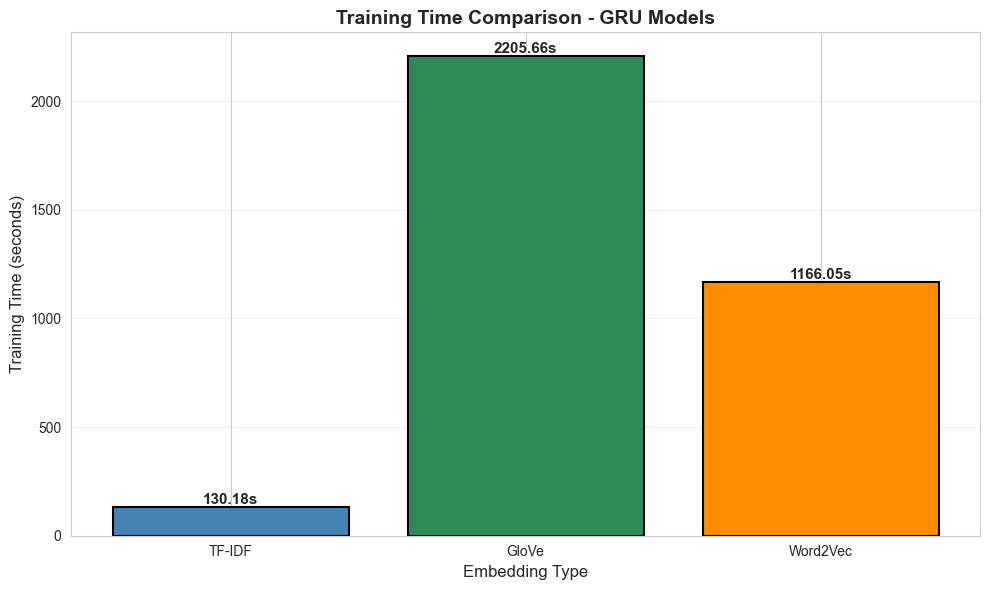

Training time chart saved to c:\Users\ngami\Downloads\Group_9_Text_classification\figures\gru\training_time_comparison_gru.png


In [ ]:
# Training time comparison
plt.figure(figsize=(10, 6))
times = [training_time_tfidf, training_time_glove, training_time_w2v]
colors = ['steelblue', 'seagreen', 'darkorange']

bars = plt.bar(embeddings, times, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Embedding Type', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.title('Training Time Comparison - GRU Models', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_GRU / 'training_time_comparison_gru.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training time chart saved to {FIGURES_GRU / 'training_time_comparison_gru.png'}")

## Summary Report

In [ ]:
# Generate summary report
summary_report = f"""
{'='*80}
GRU MODEL - SUMMARY REPORT
Group 9 - Member 4
{'='*80}

TF-IDF
{'-'*40}
  Accuracy             : {acc_tfidf:.4f}
  Precision            : {prec_tfidf:.4f}
  Recall               : {rec_tfidf:.4f}
  F1-Score             : {f1_tfidf:.4f}
  ROC-AUC              : {roc_auc_tfidf:.4f}
  Training Time        : {training_time_tfidf:.2f} seconds

GloVe
{'-'*40}
  Accuracy             : {acc_glove:.4f}
  Precision            : {prec_glove:.4f}
  Recall               : {rec_glove:.4f}
  F1-Score             : {f1_glove:.4f}
  ROC-AUC              : {roc_auc_glove:.4f}
  Training Time        : {training_time_glove:.2f} seconds

Word2Vec
{'-'*40}
  Accuracy             : {acc_w2v:.4f}
  Precision            : {prec_w2v:.4f}
  Recall               : {rec_w2v:.4f}
  F1-Score             : {f1_w2v:.4f}
  ROC-AUC              : {roc_auc_w2v:.4f}
  Training Time        : {training_time_w2v:.2f} seconds

{'='*80}
BEST OVERALL (F1-Score): {comparison_df.iloc[0]['Embedding']}
FASTEST TRAINING: {comparison_df.loc[comparison_df['Training Time (s)'].idxmin(), 'Embedding']}
{'='*80}
"""

print(summary_report)

# Save summary report
with open(RESULTS_DIR / 'summary_report.txt', 'w') as f:
    f.write(summary_report)

print(f"\nSummary report saved to {RESULTS_DIR / 'summary_report.txt'}")


GRU MODEL - SUMMARY REPORT
Group 9 - Member 4

TF-IDF
----------------------------------------
  Accuracy             : 0.8914
  Precision            : 0.8888
  Recall               : 0.8948
  F1-Score             : 0.8918
  ROC-AUC              : 0.9592
  Training Time        : 130.18 seconds

GloVe
----------------------------------------
  Accuracy             : 0.8650
  Precision            : 0.8728
  Recall               : 0.8546
  F1-Score             : 0.8636
  ROC-AUC              : 0.9415
  Training Time        : 2205.66 seconds

Word2Vec
----------------------------------------
  Accuracy             : 0.8965
  Precision            : 0.8983
  Recall               : 0.8942
  F1-Score             : 0.8963
  ROC-AUC              : 0.9589
  Training Time        : 1166.05 seconds

BEST OVERALL (F1-Score): Word2Vec
FASTEST TRAINING: TF-IDF


Summary report saved to c:\Users\ngami\Downloads\Group_9_Text_classification\results\member4_gru\summary_report.txt


## 🎉 GRU Model Training Complete!

**Results Summary:**
- ✅ GRU + TF-IDF trained and evaluated
- ✅ GRU + GloVe trained and evaluated
- ✅ GRU + Word2Vec trained and evaluated
- ✅ All models saved to `results/member4_gru/`
- ✅ Comparison table generated
- ✅ All visualizations saved to `figures/gru/`

**Next Steps:**
1. Review the comparison table to see which embedding performed best
2. Check the confusion matrices and ROC curves in the figures folder
3. Update the team report with GRU results
4. Compare GRU performance with LSTM and BiLSTM from other team members